# Recurrent neural networks for H.P Lovecraft text generation

"The color out of space" is one of my favorite tales from Lovecraft, i will use it(as well as others as the call of cthulhu) to create a recurrent neural network in tensorflow that learns his style and generates new text in his style

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn) and an example from "Deep Learning Nanodegree" on udacity. Also, some information [here at r2rt](http://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html) and from [Sherjil Ozair](https://github.com/sherjilozair/char-rnn-tensorflow) on GitHub. 

## General architecture using "Long short term memory" units in the recurrent layers

<img src="assets/charseq.jpeg" width="500">

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import time
from collections import namedtuple

import numpy as np
import tensorflow as tf
from nltk.tokenize import word_tokenize
import nltk
import itertools
import matplotlib.pyplot as plt
from time import gmtime, strftime ,localtime
import shutil
import os.path

In [3]:
# Run only the  first time nltk is used to download language
#nltk.download()

### Define conf variables and hyper parameteters 

mode = "characters" #characters or words

epochs = 3
batch_size = 64       # Sequences per batch
num_steps = 400         # Number of sequence steps per batch
lstm_size = 2048         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.000075 # Learning rate
keep_prob = 1# Dropout keep probability
negative_sampled = 100 #in words mode ,how many negative words to sample to improve trainint time

resume_from_checkpoint = True
delete_checkpoints  = False


In [4]:
mode = "characters" #characters or words

epochs = 15
batch_size = 64       # Sequences per batch
num_steps = 100         # Number of sequence steps per batch
lstm_size = 1024         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.002 # Learning rate
keep_prob = 1# Dropout keep probability
negative_sampled = 1000 #in words mode ,how many negative words to sample to improve trainint time

resume_from_checkpoint = False
delete_checkpoints  = True

In [5]:
if not resume_from_checkpoint and delete_checkpoints and os.path.exists("./checkpoints/"):
    shutil.rmtree("./checkpoints/")

### Define base text
Once trained ,the network can take base text and a sequence size and generate new text using base text as first characters in the sequence. For every element in base text wi will create a list that will store generated text as training goes, to be able to compare results between steps

In [6]:
text_to_try = ["In the first place","the night before","horror","creature","night","dream","thing","That night","mountain","Ammi","Cthulhu","raven","bird","nevermore","dead","The bird"]

#### Function that separates text into tokens(for whitespace characters, only new line is implemented, missing tabs and others=

In [7]:
def tokenize_by_words(text):
    text = text.replace("\n"," new_line_token ")
    tokens = []
    splitted =[[word_tokenize(w),' ']for w in text.split()]
    splitted = list(itertools.chain(*list(itertools.chain(*splitted))))
    
    token_list = []
    i = 0
    while i < len(splitted):
        if splitted[i] == "new_line_token":
            if   token_list[-1]==" ":
                token_list[-1] = splitted[i]
            else:
                token_list.append(splitted[i])
            i+=1
        else:
            token_list.append(splitted[i])
        i+=1
    
    return token_list

def tokenize_by_characters(text):
    return list(text)

def tokenize_text(text,mode="characters"):
    if mode == "characters":
        return tokenize_by_characters(text)
    elif mode == "words":
        return tokenize_by_words(text)
    
tokenize_text("Hello, my name is Luis Leal!\n\nFrom Guatemala",mode)
#tokenize_text("Hello, my name is Luis Leal!\n\nFrom Guatemala","words")


['H',
 'e',
 'l',
 'l',
 'o',
 ',',
 ' ',
 'm',
 'y',
 ' ',
 'n',
 'a',
 'm',
 'e',
 ' ',
 'i',
 's',
 ' ',
 'L',
 'u',
 'i',
 's',
 ' ',
 'L',
 'e',
 'a',
 'l',
 '!',
 '\n',
 '\n',
 'F',
 'r',
 'o',
 'm',
 ' ',
 'G',
 'u',
 'a',
 't',
 'e',
 'm',
 'a',
 'l',
 'a']

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [8]:
with open('corpus.txt', 'r') as f:
    text=f.read()

In [9]:
vocab = set(tokenize_text(text,mode))
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
n_vocab = len(vocab)

### Get a little portion of text for validation

In [10]:
tokenized_text = tokenize_text(text,mode)
encoded_dataset = np.array([vocab_to_int[c] for c in tokenized_text if c in vocab_to_int], dtype=np.int32)

In [11]:
validation_size = batch_size * num_steps #create a single baty
validation_start_index = len(encoded_dataset) - validation_size

encoded = encoded_dataset[:validation_start_index]
encoded_val = encoded_dataset[validation_start_index:]

In [12]:
def encoded_to_text(encoded):
    return "".join([int_to_vocab[number] for number in encoded])

print(encoded_to_text(encoded_val[0:100]))

ognac, Brown. I'll go on in a moment,
Gregory....

'Well, I felt to the right, and my fingers touche


In [13]:
val_text =encoded_to_text(encoded_val)
text = encoded_to_text(encoded)

Let's check out the first 100 characters of train and validation, make sure everything is peachy.  line of a book ever.

In [14]:
text[:100]

'THE COLOUR OUT OF SPACE\n\nWest of Arkham the hills rise wild, and there are valleys with deep woods t'

In [15]:
val_text[:100]

"ognac, Brown. I'll go on in a moment,\nGregory....\n\n'Well, I felt to the right, and my fingers touche"

And we can see the characters encoded as integersin both train and validation

In [16]:
encoded[:100]

array([ 55,  23,  53,  42,  87, 108, 117, 108,  91,  77,  42, 108,  91,
        55,  42, 108,   7,  42,  64,  93,  61,  87,  53, 101, 101, 103,
        83,  38,  99,  42,  27, 107,  42,  61,  26,  45,   0, 121, 106,
        42,  99,   0,  83,  42,   0,  51,  78,  78,  38,  42,  26,  51,
        38,  83,  42,   2,  51,  78,  32,  79,  42, 121,  46,  32,  42,
        99,   0,  83,  26,  83,  42, 121,  26,  83,  42,  22, 121,  78,
        78,  83,  54,  38,  42,   2,  51,  99,   0,  42,  32,  83,  83,
        71,  42,   2,  27,  27,  32,  38,  42,  99], dtype=int32)

In [17]:
encoded_val[0:100]

array([ 27,  50,  46, 121,   4,  79,  42,  67,  26,  27,   2,  46,  70,
        42,  34,  49,  78,  78,  42,  50,  27,  42,  27,  46,  42,  51,
        46,  42, 121,  42, 106,  27, 106,  83,  46,  99,  79, 101,  73,
        26,  83,  50,  27,  26,  54,  70,  70,  70,  70, 101, 101,  49,
       103,  83,  78,  78,  79,  42,  34,  42, 107,  83,  78,  99,  42,
        99,  27,  42,  99,   0,  83,  42,  26,  51,  50,   0,  99,  79,
        42, 121,  46,  32,  42, 106,  54,  42, 107,  51,  46,  50,  83,
        26,  38,  42,  99,  27,  37,   4,   0,  83], dtype=int32)

Since the network is working with individual english tokens, it's similar to a classification problem in which we are trying to predict the next character from the previous text.  Here's how many 'classes' our network has to pick from.

In [18]:
len(vocab)

127

## Making training mini-batches

Here is where we'll make our mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>
We have our text encoded as integers as one long array in `encoded`. Let's create a function that will give us an iterator for our batches. I like using [generator functions](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) to do this. Then we can pass `encoded` into this function and get our batch generator.

The first thing we need to do is discard some of the text so we only have completely full batches. Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences) and $M$ is the number of steps. Then, to get the number of batches we can make from some array `arr`, you divide the length of `arr` by the batch size. Once you know the number of batches and the batch size, you can get the total number of characters to keep.

After that, we need to split `arr` into $N$ sequences. You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences (`n_seqs` below), let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$ where $K$ is the number of batches.

Now that we have this array, we can iterate through it to get our batches. The idea is each batch is a $N \times M$ window on the array. For each subsequent batch, the window moves over by `n_steps`. We also want to create both the input and target arrays. Remember that the targets are the inputs shifted over one character. You'll usually see the first input character used as the last target character, so something like this:
```python
y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
```
where `x` is the input batch and `y` is the target batch.

The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of steps in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `n_steps` wide.

In [19]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the batch size and number of batches we can make
    batch_size = n_seqs * n_steps 
    n_batches =  len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr =  arr[:n_batches*batch_size]
    
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs,-1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:,n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros(x.shape)
        y[:,:-1],y[:,-1] = x[:,1:] ,x[:,0]
        yield x, y

Now I'll make my data sets and we can check out what's going on here. Here I'm going to use a batch size of 10 and 50 sequence steps.

In [20]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)

In [21]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[ 55  23  53  42  87 108 117 108  91  77]
 [ 38  79  42  34  42 121 106  42   0 121]
 [ 83  42  83 121  26  99   0  42   0 121]
 [ 42 121  42 106  27  46  99   0  42  38]
 [107  42   0  51  38  42  27   2  46  42]
 [ 42   3  83  50  37  51  78  83  42  99]
 [ 99  42   2   0  51   4   0  42  32  26]
 [  3  27  27  45  38  42  38  99  27  78]
 [ 83  38  43  42  38  27  42  99   0 121]
 [121  50  37  83  42  71 121  51  46  42]]

y
 [[ 23.  53.  42.  87. 108. 117. 108.  91.  77.  42.]
 [ 79.  42.  34.  42. 121. 106.  42.   0. 121.  26.]
 [ 42.  83. 121.  26.  99.   0.  42.   0. 121.  32.]
 [121.  42. 106.  27.  46.  99.   0.  42.  38.  51.]
 [ 42.   0.  51.  38.  42.  27.   2.  46.  42.  32.]
 [  3.  83.  50.  37.  51.  78.  83.  42.  99.   0.]
 [ 42.   2.   0.  51.   4.   0.  42.  32.  26.  83.]
 [ 27.  27.  45.  38.  42.  38.  99.  27.  78.  83.]
 [ 38.  43.  42.  38.  27.  42.  99.   0. 121.  99.]
 [ 50.  37.  83.  42.  71. 121.  51.  46.  42.  37.]]


## Building the model

Below is where you'll build the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="assets/charRNN.png" width=500px>


### Inputs

First off we'll create our input placeholders. As usual we need placeholders for the training data and the targets. We'll also create a placeholder for dropout layers called `keep_prob`. This will be a scalar, that is a 0-D tensor. To make a scalar, you create a placeholder without giving it a size.

In [22]:
def build_inputs(batch_size, num_steps):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.int32,[batch_size,num_steps],name="inputs")
    targets = tf.placeholder(tf.int32,[batch_size,num_steps],name="targets")
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32,name="keep_prob")
    
    return inputs, targets, keep_prob

### LSTM Cell

Here we will create the LSTM cell we'll use in the hidden layer. We'll use this cell as a building block for the RNN. So we aren't actually defining the RNN here, just the type of cell we'll use in the hidden layer.

We first create a basic LSTM cell with

```python
lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
```

where `num_units` is the number of units in the hidden layers in the cell. Then we can add dropout by wrapping it with 

```python
tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
```
You pass in a cell and it will automatically add dropout to the inputs or outputs. Finally, we can stack up the LSTM cells into layers with [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell). With this, you pass in a list of cells and it will send the output of one cell into the next cell. For example,

```python
tf.contrib.rnn.MultiRNNCell([cell]*num_layers)
```

This might look a little weird if you know Python well because this will create a list of the same `cell` object. However, TensorFlow will create different weight matrices for all `cell` objects. Even though this is actually multiple LSTM cells stacked on each other, you can treat the multiple layers as one cell.

We also need to create an initial cell state of all zeros. This can be done like so

```python
initial_state = cell.zero_state(batch_size, tf.float32)
```


In [23]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    # Use a basic LSTM cell
    # Add dropout to the cell outputs
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper( tf.contrib.rnn.BasicLSTMCell(lstm_size),output_keep_prob = keep_prob) for _ in range(num_layers)])
    initial_state = cell.zero_state(batch_size,tf.float32)
    
    return cell, initial_state

### RNN Output

Here we'll create the output layer. We need to connect the output of the RNN cells to a full connected layer with a softmax output. The softmax output gives us a probability distribution we can use to predict the next character, so we want this layer to have size $C$, the number of classes/characters we have in our text.

If our input has batch size $N$, number of steps $M$, and the hidden layer has $L$ hidden units, then the output is a 3D tensor with size $N \times M \times L$. The output of each LSTM cell has size $L$, we have $M$ of them, one for each sequence step, and we have $N$ sequences. So the total size is $N \times M \times L$. 

We are using the same fully connected layer, the same weights, for each of the outputs. Then, to make things easier, we should reshape the outputs into a 2D tensor with shape $(M * N) \times L$. That is, one row for each sequence and step, where the values of each row are the output from the LSTM cells. We get the LSTM output as a list, `lstm_output`. First we need to concatenate this whole list into one array with [`tf.concat`](https://www.tensorflow.org/api_docs/python/tf/concat). Then, reshape it (with `tf.reshape`) to size $(M * N) \times L$.

One we have the outputs reshaped, we can do the matrix multiplication with the weights. We need to wrap the weight and bias variables in a variable scope with `tf.variable_scope(scope_name)` because there are weights being created in the LSTM cells. TensorFlow will throw an error if the weights created here have the same names as the weights created in the LSTM cells, which they will be default. To avoid this, we wrap the variables in a variable scope so we can give them unique names.


In [24]:
def build_output(lstm_output, in_size, out_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''
    print(lstm_output)
    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output,axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(seq_output,[-1,in_size])
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal((in_size, out_size),stddev=0.1))
        softmax_b = tf.Variable(tf.zeros([out_size]))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits =  tf.add(tf.matmul(x,softmax_w),softmax_b) 
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits,name ="out")
    
    return out, logits,softmax_w,softmax_b,x

### Training loss

Next up is the training loss. We get the logits and targets and calculate the softmax cross-entropy loss. First we need to one-hot encode the targets, we're getting them as encoded characters. Then, reshape the one-hot targets so it's a 2D tensor with size $(M*N) \times C$ where $C$ is the number of classes/characters we have. Remember that we reshaped the LSTM outputs and ran them through a fully connected layer with $C$ units. So our logits will also have size $(M*N) \times C$.

Then we run the logits and targets through `tf.nn.softmax_cross_entropy_with_logits` and find the mean to get the loss.

In [25]:
def build_loss(lstm_output,logits, targets, lstm_size, num_classes,softmax_w,softmax_b):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    # One-hot encode targets and reshape to match logits, one row per sequence per step
    y_one_hot = tf.one_hot(targets,num_classes)
    y_reshaped =  tf.reshape(y_one_hot,logits.get_shape())
    
    
    # Softmax cross entropy loss
    if mode == "characters":
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_reshaped))
    elif mode == "words":
        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(tf.transpose(softmax_w),softmax_b,tf.reshape(tf.argmax( y_reshaped,axis = 1),shape=(y_reshaped.get_shape()[0],1)),tf.concat(lstm_output,axis=1),negative_sampled,len(vocab)))
    
    return loss

### Optimizer

Here we build the optimizer. Normal RNNs have have issues gradients exploding and disappearing. LSTMs fix the disappearance problem, but the gradients can still grow without bound. To fix this, we can clip the gradients above some threshold. That is, if a gradient is larger than that threshold, we set it to the threshold. This will ensure the gradients never grow overly large. Then we use an AdamOptimizer for the learning step.

In [26]:
def build_optimizer(loss, learning_rate, grad_clip,global_step):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
        global_step: to control the total number of train steps
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars),global_step)
    
    return optimizer

### Build the network

Now we can put all the pieces together and build a class for the network. To actually run data through the LSTM cells, we will use [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/nn/dynamic_rnn). This function will pass the hidden and cell states across LSTM cells appropriately for us. It returns the outputs for each LSTM cell at each step for each sequence in the mini-batch. It also gives us the final LSTM state. We want to save this state as `final_state` so we can pass it to the first LSTM cell in the the next mini-batch run. For `tf.nn.dynamic_rnn`, we pass in the cell and initial state we get from `build_lstm`, as well as our input sequences. Also, we need to one-hot encode the inputs before going into the RNN. 


In [27]:
class CharRNN:
    
    def __init__(self, num_classes, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False,device = "/device:GPU:0"):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        with tf.device(device):
            self.global_step_tensor = tf.Variable(0,trainable=False,name = "global_step")
            # Build the input placeholder tensors
            self.inputs, self.targets, self.keep_prob = build_inputs(batch_size,num_steps)
            # Build the LSTM cell
            cell, self.initial_state = build_lstm(lstm_size,num_layers,batch_size,self.keep_prob)
            ### Run the data through the RNN layers
            # First, one-hot encode the input tokens
            x_one_hot = tf.one_hot(self.inputs,num_classes)

            self.grad_clip  = grad_clip
            # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
            outputs, state = tf.nn.dynamic_rnn(cell,x_one_hot,initial_state=self.initial_state)
            self.final_state = state

            # Get softmax predictions and logits
            self.prediction, self.logits ,self.softmax_w,self.softmax_b,self.lstm_output_reshaped  = build_output(outputs,lstm_size,num_classes)

            # Loss and optimizer (with gradient clipping)
            self.loss =  build_loss(self.lstm_output_reshaped ,self.logits,self.targets,lstm_size,num_classes,self.softmax_w,self.softmax_b)
            self.optimizer = build_optimizer(self.loss,learning_rate,grad_clip,self.global_step_tensor)

## Hyperparameters

Here are the hyperparameters for the network.

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.

Here's some good advice from Andrej Karpathy on training the network:. 

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `lstm_size` and `num_layers`. I would advise that you always use `num_layers` of either 2/3. The `lstm_size` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `lstm_size` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

In [28]:
def get_number_of_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        #print(shape)
        #print(len(shape))
        variable_parameters = 1
        
        for dim in shape:
            #print(dim)
            variable_parameters*=dim.value
        #print(variable_parameters)
        total_parameters+= variable_parameters
    return total_parameters

In [29]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`


In [30]:
losses = {"train":[],"validation":[]}
x_steps = list()

In [31]:
#epochs = 1
# Save every N iterations
save_every_n =10
print_loss_every_n = 20
sample_every = 500
print_epoch_time_every = 1


model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate,device="/device:GPU:0")
    #print("after model")

saver = tf.train.Saver(max_to_keep=5)
print("Training starting at time:",strftime("%Y-%m-%d %H:%M:%S", localtime()))
train_start_time = time.time()
with tf.Session(config=tf.ConfigProto(log_device_placement=True,allow_soft_placement= True)) as sess:
    sess.run(tf.global_variables_initializer())
    print("Number of parameters:",get_number_of_parameters(),"Dataset size:",len(encoded))
    #print("after initializer")
    if resume_from_checkpoint:
        latest_checkpoint = tf.train.latest_checkpoint('checkpoints')
        saver.restore(sess, latest_checkpoint)
    counter = 0
    for e in range(epochs):
        # Train network
        epoch_start = time.time()

        new_state = sess.run(model.initial_state)
        loss = 0
        for x, y in get_batches(encoded, batch_size, num_steps):


            start = time.time()
            feed = {model.inputs: x,
                        model.targets: y,
                        model.keep_prob: keep_prob,
                        model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                     model.final_state, 
                                                     model.optimizer], 
                                                     feed_dict=feed)


            end = time.time()
            if counter%print_loss_every_n == 0:
                val_batches = get_batches(encoded_val,int(len(encoded_val)/num_steps),num_steps)
                x_val,y_val = next(val_batches)

                val_dict = {model.inputs: x_val,
                                model.targets: y_val,
                                model.keep_prob: 1,
                                model.initial_state: new_state}

                val_loss,prediction = sess.run([model.loss,model.prediction],feed_dict=val_dict)

                losses["train"].append(batch_loss)
                losses["validation"].append(val_loss)


                global_step = tf.train.global_step(sess,model.global_step_tensor)
                x_steps.append(global_step)

                print('Epoch: {}/{}... '.format(e+1, epochs),
                          'Training Step: {}... '.format(global_step),
                          'Training loss: {:.4f}... '.format(batch_loss),
                          'Val loss: {:.4f}... '.format(val_loss),
                          '{:.4f} sec/batch'.format((end-start)))

            if (counter % save_every_n == 0):
                global_step = tf.train.global_step(sess,model.global_step_tensor)
                saver.save(sess, "checkpoints/m{}_i{}_l{}.ckpt".format(mode,global_step, lstm_size))

            counter += 1
                #learning_rate*=0.75
                #model.optimizer = build_optimizer(model.loss,learning_rate,model.grad_clip,model.global_step_tensor)

        epoch_end = time.time()


        if ((e+1) % print_epoch_time_every== 0):
            print('Epoch {}/{} time:{}...'.format(e+1,epochs,epoch_end-epoch_start),
                     " finished at",strftime("%Y-%m-%d %H:%M:%S", localtime()))


    global_step = tf.train.global_step(sess,model.global_step_tensor)
    saver.save(sess, "checkpoints/m{}_i{}_l{}.ckpt".format(mode,global_step, lstm_size))

print("Training ending at time:",strftime("%Y-%m-%d %H:%M:%S", localtime()))
print("Trainint total time:",time.time()-train_start_time)

Tensor("rnn/transpose_1:0", shape=(64, 100, 1024), dtype=float32, device=/device:GPU:0)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Training starting at time: 2019-10-24 09:46:49
Number of parameters: 13241471 Dataset size: 6260920
Epoch: 1/15...  Training Step: 1...  Training loss: 4.8409...  Val loss: 4.1954...  0.4062 sec/batch
Epoch: 1/15...  Training Step: 21...  Training loss: 3.1527...  Val loss: 3.2474...  0.1569 sec/batch
Epoch: 1/15...  Training Step: 41...  Training loss: 3.0631...  Val loss: 3.1550...  0.1566 sec/batch
Epoch: 1/15...  Training Step: 61...  Training loss: 3.0210...  Val loss: 3.1333...  0.1593 sec/batch
Epoch: 1/15...  Training Step: 81...  Training loss: 3.0309...  Val loss: 3.1217...  0.1592 sec/batch
Epoch: 1/15...  Training Step: 101...  Training loss: 2.9637...  Val loss: 3.1147...  0.1588 sec/batch
Epoch: 1

Epoch: 2/15...  Training Step: 1481...  Training loss: 1.5779...  Val loss: 1.6632...  0.1587 sec/batch
Epoch: 2/15...  Training Step: 1501...  Training loss: 1.5546...  Val loss: 1.6574...  0.1610 sec/batch
Epoch: 2/15...  Training Step: 1521...  Training loss: 1.5498...  Val loss: 1.6629...  0.1628 sec/batch
Epoch: 2/15...  Training Step: 1541...  Training loss: 1.5537...  Val loss: 1.6487...  0.1619 sec/batch
Epoch: 2/15...  Training Step: 1561...  Training loss: 1.5223...  Val loss: 1.6468...  0.1648 sec/batch
Epoch: 2/15...  Training Step: 1581...  Training loss: 1.4905...  Val loss: 1.6543...  0.1624 sec/batch
Epoch: 2/15...  Training Step: 1601...  Training loss: 1.5274...  Val loss: 1.6571...  0.1620 sec/batch
Epoch: 2/15...  Training Step: 1621...  Training loss: 1.5107...  Val loss: 1.6579...  0.1631 sec/batch
Epoch: 2/15...  Training Step: 1641...  Training loss: 1.4929...  Val loss: 1.6456...  0.1615 sec/batch
Epoch: 2/15...  Training Step: 1661...  Training loss: 1.4764...

Epoch: 4/15...  Training Step: 3041...  Training loss: 1.3158...  Val loss: 1.5095...  0.1639 sec/batch
Epoch: 4/15...  Training Step: 3061...  Training loss: 1.2881...  Val loss: 1.5190...  0.1613 sec/batch
Epoch: 4/15...  Training Step: 3081...  Training loss: 1.3151...  Val loss: 1.5095...  0.1613 sec/batch
Epoch: 4/15...  Training Step: 3101...  Training loss: 1.3473...  Val loss: 1.5105...  0.1628 sec/batch
Epoch: 4/15...  Training Step: 3121...  Training loss: 1.3700...  Val loss: 1.5030...  0.1628 sec/batch
Epoch: 4/15...  Training Step: 3141...  Training loss: 1.3607...  Val loss: 1.5196...  0.1646 sec/batch
Epoch: 4/15...  Training Step: 3161...  Training loss: 1.3467...  Val loss: 1.4961...  0.1620 sec/batch
Epoch: 4/15...  Training Step: 3181...  Training loss: 1.3053...  Val loss: 1.5247...  0.1708 sec/batch
Epoch: 4/15...  Training Step: 3201...  Training loss: 1.3485...  Val loss: 1.4994...  0.1604 sec/batch
Epoch: 4/15...  Training Step: 3221...  Training loss: 1.3359...

Epoch: 5/15...  Training Step: 4621...  Training loss: 1.2335...  Val loss: 1.4973...  0.1647 sec/batch
Epoch: 5/15...  Training Step: 4641...  Training loss: 1.2436...  Val loss: 1.4916...  0.1633 sec/batch
Epoch: 5/15...  Training Step: 4661...  Training loss: 1.2610...  Val loss: 1.4926...  0.1611 sec/batch
Epoch: 5/15...  Training Step: 4681...  Training loss: 1.2551...  Val loss: 1.4676...  0.1649 sec/batch
Epoch: 5/15...  Training Step: 4701...  Training loss: 1.2632...  Val loss: 1.4928...  0.1640 sec/batch
Epoch: 5/15...  Training Step: 4721...  Training loss: 1.2202...  Val loss: 1.4842...  0.1628 sec/batch
Epoch: 5/15...  Training Step: 4741...  Training loss: 1.2611...  Val loss: 1.4677...  0.1621 sec/batch
Epoch: 5/15...  Training Step: 4761...  Training loss: 1.2269...  Val loss: 1.4752...  0.1642 sec/batch
Epoch: 5/15...  Training Step: 4781...  Training loss: 1.1891...  Val loss: 1.4661...  0.1606 sec/batch
Epoch: 5/15...  Training Step: 4801...  Training loss: 1.2487...

Epoch: 7/15...  Training Step: 6181...  Training loss: 1.1927...  Val loss: 1.4860...  0.1626 sec/batch
Epoch: 7/15...  Training Step: 6201...  Training loss: 1.1782...  Val loss: 1.4816...  0.1631 sec/batch
Epoch: 7/15...  Training Step: 6221...  Training loss: 1.1666...  Val loss: 1.4842...  0.1640 sec/batch
Epoch: 7/15...  Training Step: 6241...  Training loss: 1.1944...  Val loss: 1.4910...  0.1638 sec/batch
Epoch: 7/15...  Training Step: 6261...  Training loss: 1.2054...  Val loss: 1.4832...  0.1635 sec/batch
Epoch: 7/15...  Training Step: 6281...  Training loss: 1.2167...  Val loss: 1.4787...  0.1646 sec/batch
Epoch: 7/15...  Training Step: 6301...  Training loss: 1.2261...  Val loss: 1.4910...  0.1753 sec/batch
Epoch: 7/15...  Training Step: 6321...  Training loss: 1.1616...  Val loss: 1.4898...  0.1593 sec/batch
Epoch: 7/15...  Training Step: 6341...  Training loss: 1.1857...  Val loss: 1.4700...  0.1616 sec/batch
Epoch: 7/15...  Training Step: 6361...  Training loss: 1.2075...

Epoch: 8/15...  Training Step: 7761...  Training loss: 1.1562...  Val loss: 1.4661...  0.1613 sec/batch
Epoch: 8/15...  Training Step: 7781...  Training loss: 1.1765...  Val loss: 1.4763...  0.1623 sec/batch
Epoch: 8/15...  Training Step: 7801...  Training loss: 1.1439...  Val loss: 1.4644...  0.1619 sec/batch
Epoch: 8/15...  Training Step: 7821...  Training loss: 1.1549...  Val loss: 1.4740...  0.1634 sec/batch
Epoch 8/15 time:218.37976050376892...  finished at 2019-10-24 10:15:50
Epoch: 9/15...  Training Step: 7841...  Training loss: 1.1534...  Val loss: 1.4774...  0.1637 sec/batch
Epoch: 9/15...  Training Step: 7861...  Training loss: 1.1445...  Val loss: 1.4939...  0.1643 sec/batch
Epoch: 9/15...  Training Step: 7881...  Training loss: 1.1589...  Val loss: 1.4799...  0.1637 sec/batch
Epoch: 9/15...  Training Step: 7901...  Training loss: 1.1576...  Val loss: 1.4732...  0.1638 sec/batch
Epoch: 9/15...  Training Step: 7921...  Training loss: 1.1422...  Val loss: 1.5065...  0.1630 sec

Epoch: 10/15...  Training Step: 9321...  Training loss: 1.1304...  Val loss: 1.5121...  0.1749 sec/batch
Epoch: 10/15...  Training Step: 9341...  Training loss: 1.1488...  Val loss: 1.4688...  0.1590 sec/batch
Epoch: 10/15...  Training Step: 9361...  Training loss: 1.1188...  Val loss: 1.4937...  0.1618 sec/batch
Epoch: 10/15...  Training Step: 9381...  Training loss: 1.0802...  Val loss: 1.5037...  0.1667 sec/batch
Epoch: 10/15...  Training Step: 9401...  Training loss: 1.1227...  Val loss: 1.5001...  0.1667 sec/batch
Epoch: 10/15...  Training Step: 9421...  Training loss: 1.1474...  Val loss: 1.5018...  0.1623 sec/batch
Epoch: 10/15...  Training Step: 9441...  Training loss: 1.1090...  Val loss: 1.5049...  0.1637 sec/batch
Epoch: 10/15...  Training Step: 9461...  Training loss: 1.1719...  Val loss: 1.5181...  0.1684 sec/batch
Epoch: 10/15...  Training Step: 9481...  Training loss: 1.0959...  Val loss: 1.4974...  0.1642 sec/batch
Epoch: 10/15...  Training Step: 9501...  Training loss:

Epoch: 12/15...  Training Step: 10861...  Training loss: 1.1107...  Val loss: 1.5428...  0.1617 sec/batch
Epoch: 12/15...  Training Step: 10881...  Training loss: 1.1367...  Val loss: 1.5224...  0.1631 sec/batch
Epoch: 12/15...  Training Step: 10901...  Training loss: 1.1473...  Val loss: 1.5200...  0.1644 sec/batch
Epoch: 12/15...  Training Step: 10921...  Training loss: 1.1349...  Val loss: 1.5280...  0.1749 sec/batch
Epoch: 12/15...  Training Step: 10941...  Training loss: 1.1427...  Val loss: 1.5345...  0.1605 sec/batch
Epoch: 12/15...  Training Step: 10961...  Training loss: 1.1083...  Val loss: 1.5506...  0.1621 sec/batch
Epoch: 12/15...  Training Step: 10981...  Training loss: 1.1544...  Val loss: 1.5277...  0.1597 sec/batch
Epoch: 12/15...  Training Step: 11001...  Training loss: 1.1351...  Val loss: 1.5411...  0.1630 sec/batch
Epoch: 12/15...  Training Step: 11021...  Training loss: 1.1494...  Val loss: 1.5567...  0.1635 sec/batch
Epoch: 12/15...  Training Step: 11041...  Trai

Epoch: 13/15...  Training Step: 12401...  Training loss: 1.0829...  Val loss: 1.5532...  0.1637 sec/batch
Epoch: 13/15...  Training Step: 12421...  Training loss: 1.0876...  Val loss: 1.5406...  0.1637 sec/batch
Epoch: 13/15...  Training Step: 12441...  Training loss: 1.0855...  Val loss: 1.5200...  0.1766 sec/batch
Epoch: 13/15...  Training Step: 12461...  Training loss: 1.0780...  Val loss: 1.5487...  0.1617 sec/batch
Epoch: 13/15...  Training Step: 12481...  Training loss: 1.0575...  Val loss: 1.5436...  0.1613 sec/batch
Epoch: 13/15...  Training Step: 12501...  Training loss: 1.1022...  Val loss: 1.5211...  0.1696 sec/batch
Epoch: 13/15...  Training Step: 12521...  Training loss: 1.0778...  Val loss: 1.5228...  0.1632 sec/batch
Epoch: 13/15...  Training Step: 12541...  Training loss: 1.0587...  Val loss: 1.5090...  0.1632 sec/batch
Epoch: 13/15...  Training Step: 12561...  Training loss: 1.0694...  Val loss: 1.5130...  0.1641 sec/batch
Epoch: 13/15...  Training Step: 12581...  Trai

Epoch: 15/15...  Training Step: 13921...  Training loss: 1.0375...  Val loss: 1.5273...  0.1627 sec/batch
Epoch: 15/15...  Training Step: 13941...  Training loss: 1.0465...  Val loss: 1.5273...  0.1657 sec/batch
Epoch: 15/15...  Training Step: 13961...  Training loss: 1.0873...  Val loss: 1.5458...  0.1622 sec/batch
Epoch: 15/15...  Training Step: 13981...  Training loss: 1.0583...  Val loss: 1.5503...  0.1646 sec/batch
Epoch: 15/15...  Training Step: 14001...  Training loss: 1.0570...  Val loss: 1.5308...  0.1636 sec/batch
Epoch: 15/15...  Training Step: 14021...  Training loss: 1.0798...  Val loss: 1.5346...  0.1643 sec/batch
Epoch: 15/15...  Training Step: 14041...  Training loss: 1.0422...  Val loss: 1.5595...  0.1629 sec/batch
Epoch: 15/15...  Training Step: 14061...  Training loss: 1.0614...  Val loss: 1.5749...  0.1670 sec/batch
Epoch: 15/15...  Training Step: 14081...  Training loss: 1.0391...  Val loss: 1.5533...  0.1626 sec/batch
Epoch: 15/15...  Training Step: 14101...  Trai

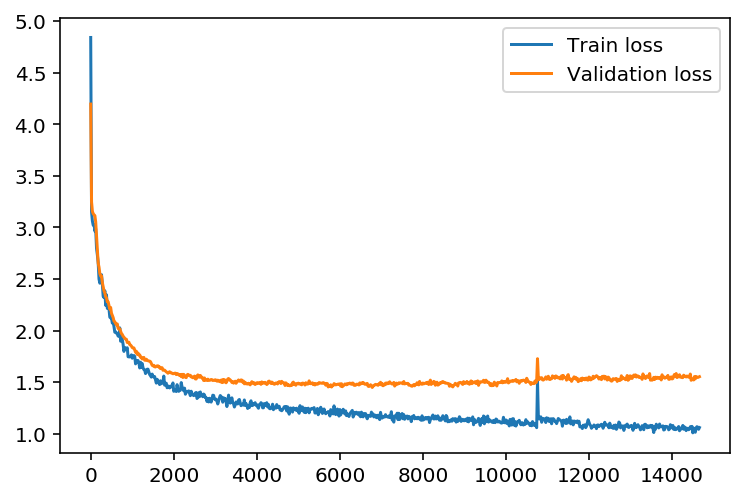

In [32]:
plt.plot(x_steps,losses["train"],label="Train loss")
plt.plot(x_steps,losses["validation"],label="Validation loss")
plt.legend()
_ = plt.ylim()

#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

In [33]:
checkpoints = tf.train.get_checkpoint_state('checkpoints')

## Sampling final trained model

Now that the network is trained, we'll can use it to generate new text. The idea is that we pass in a character, then the network will predict the next character. We can use the new one, to predict the next one. And we keep doing this to generate all new text. I also included some functionality to prime the network with some text by passing in a string and building up a state from that.

The network gives us predictions for each character. To reduce noise and make things a little less random, I'm going to only choose a new character from the top N most likely characters.



In [34]:
def sample(checkpoint, n_samples, lstm_size, vocab_size, prime="The ",mode="characters"):
    print(mode)
    samples = tokenize_text(prime,mode)
    model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
    with tf.Session(config=tf.ConfigProto(log_device_placement=True,allow_soft_placement= True)) as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in tokenize_text(prime,mode):
            x = np.zeros((1, 1))
            x[0,0] = vocab_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, len(vocab))
            samples.append(int_to_vocab[c])
        
    return ''.join(samples).replace("new_line_token","\n")

Here, pass in the path to a checkpoint and sample from the network.

In [35]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints/mcharacters_i14670_l1024.ckpt'

## Generate new text from "base" text

In [36]:

checkpoint = tf.train.latest_checkpoint('checkpoints')


samples = list()
for text in text_to_try:
    #print("------------------------",text)
    samples.append( sample(checkpoint, 500, lstm_size, len(vocab), prime=text,mode=mode))
    #print(samp)
    #print("------------------------")

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO

In [37]:
for i in range(len(text_to_try)):
    text = text_to_try[i]
    generated = samples[i]
    print("------------------------",text)
    print(generated)
    print("------------------------")

------------------------ In the first place
In the first placer imprisoned me.

"It was such it will be seen and withdrow if I have already sat in my hand. The terror and plants
that saw beyond which I have made in the box. As the cat was also to say a sorrowful caution it sometimes and men alone. And why we glimps myself to the sound, I felt some three miles, that I have never before been able to
start in the
seventh of Old Man of the City.

    The murderer might recall and do but one
place where the waterfronto brought in this blazing companion, I could 
------------------------
------------------------ the night before
the night before there was always shot and frightened the pale fire-place till a small slittering sea was noted. I steeped with a sudden past and particularly
puzzled by the spot without any parallel tones in the sea of dank, masonrent stars on the bottomless sea-breezies and water. And we compoied the man, and I felt that this was told, we suspected that the power o

In [38]:
tf.train.get_checkpoint_state('checkpoints')

model_checkpoint_path: "checkpoints/mcharacters_i14670_l1024.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i14631_l1024.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i14641_l1024.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i14651_l1024.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i14661_l1024.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i14670_l1024.ckpt"

In [39]:
generated = sample(checkpoint, 5000, lstm_size, len(vocab), prime="The old folk have gone away",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
The old folk have gone away into which the great monstrous body in the courts of twenty-sech, would rend a passage through the stakes. There who have come back we went to the blackest sea. A longer weather- which has been, as the water follows that world became all outland, but the sound grew angly in the strong and splundish springt, which well dinned to the windows and the shapeless of the pestilential past and all their strange but beliefs which the bridge was a strong and shining overhead, but the chief stone broods with the grey chair and the glowing before the crowd, whervistoay, so much, if we must still realise that it would prove to be an important servants. Then there were the great cavern with singular success, and that atyle to share the sharp tone, but the pathetic sun had lain, to be the materia

In [40]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="The thing that should not be",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
The thing that should not be too word; but, and soovered and command and let all breath, and to be sates to be sure, and though it moved abroady with a shape, and so great to be also that its boy below the forest, before the task of medical and sinister stables and shopings, and soon felt a principled secret cult-wall of stronger and more than anomalies—the green-strown, a blundering blessed stream of that stars they face and beneath, and seemed to be seated from the great body, a smarting and incredible assembly because they saw them the control of sleep, as well as of simple beings, and it was the sound of the plague and back over this shelf-proving carpet, but afterward should here say that the point was introduced, and starting over the wood and should reason.
       The servants, who will be taken into t

In [41]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE THING THAT LURKS IN GUATEMALA CITY\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
THE THING THAT LURKS IN GUATEMALA CITY

“Nell, you see where she is.”
“Not call us in some hesitation when she
died on and stare
and watched him. “What do all right him sick, because he has gone without a long time, and a sent men have shown that when there was
company in the house of chaos.”
“I want to stay after Mrs. Dudley’s silver key,” Theodora said. “But put in her manner of solitude. And his
door said, “I will learn the wood on her love about it, but there was a little story on the sea.”
“I was going to spar the table in the woods at there
was it for a more serious way to see. Soon as soon aggrative of the back of her shoulders and
the doctor’s simplicity there was any madness termit. Treating, half an inside there was silent and attemptet, and three men went into stars foothiving at their bronze stone

In [42]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE NIGHTMARE IN GUATEMALA CITY\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
THE NIGHTMARE IN GUATEMALA CITY

I called again to the southern side. I sprang up to the waltz, whose glimmering wonder seems to happy tracery than any of
their approaching and soul.

"And that’s we could not, for all the world
it is but a far frame with the window.

II shall say that all that the boy's lips, and with their work on the sky, and a centurious shrouken armed branches off the church. Here, however, were starting on his body on the stricken stream as
in a captive and half-beautiful spear wells before the shelves of the palace. And he had blown a rave-mind of the bright and shrunk which would perhaps be an absence of men, and the fiends heard him; but it would be found all our
simplerge with a good degree or proportion to the room and spoke. Her sister said he was thrown over. In fact, he felt him 

In [43]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="ONCE UPON A CREEPY NIGHT\n\nAll saints eve magic was mysterious",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
ONCE UPON A CREEPY NIGHT

All saints eve magic was mysterious there were then an opening. Any ought to home.
     As the sign of
sing-savages was stubby to
strength. The sinister hideous size was not very simple and more than as he spoke:

'And the shock is not,” she said. 'If you
will remain to you. If you would be the same thought that you’ll glore the board and tell ye look if you
good olg, and she got a lot, and will gentle some o’ the book is.”
     To the stupendous piping warder of Septement's room. And he spoke of my own statelious past he could, and seemed to be searching a little resort to the ravine, wholly upon the beloved, who had become suddenly convinced that the crucialists of the
primeval chain, who spoke of the precise place in the wall on the river blue of two figures which had stretched fr

In [44]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="I have never been so afraid in my life. The trembling of the legs is uncontrollable. I do not think I survive tonight...",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
I have never been so afraid in my life. The trembling of the legs is uncontrollable. I do not think I survive tonight...looking dizzily deeply to the roar of an accord above. There was something all sealed as to watch me. I secured tears on to the southern wall. As I said that this man was absolutely not a single primal creature as I had always swept up and bright white, and that the wind died about, and all the churches they brought a signal we had seen in sprightly stone of brown box batteries, were not altogatelfore of that window about any thing which I had laughed. At the true wall that second out of the spectre, with all merhiment to the police sound. It was a great strong pervasive trace of the pale action of a birds above the river I slowly drove, as if from the bottom party, all stopped toward the so

In [45]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE THING THAT SHOULD NOT BE\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
THE THING THAT SHOULD NOT BE

 THAT SHUND

I. ThE BAATAR

   By the war what we have all this before, but in the early top great book were blotted. The stern was recalled, while the strange mill of Desports would be an idea and she was a vastly simple age the world’s sourry.

These, however, we were a four-hour about it. A boundless
beautiful note were neatly almost blotted off.
     “It was all tha performance in that book an interveneus about that? That there
would have been a small sea, that is with an arrive of teeth, who will
begin, is to think of how strange, that is not
there, and that
three who shalls and make it safe, and hauled to throw it for the bells! And the bright wonder would stop, with an expectation in her sort of block--and where is
the body and the bright people were not so sure, since you

In [46]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="the creature of the night",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 1024), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i14670_l1024.ckpt
the creature of the night seemed to be to see if they might be learned.
     It was the task of a present appearance. Toward the farewell was seekinately and perhaps as they when struggling and glitter again.

           To the sounding past moon which some sail was seen to see that I had already been thrown off by some present consideration from my belly; the best marked before I had bring about it, an indifferent masquemas and place of boys and concord and palpious treating.
     As to the councelliness which the palaeogram might have been pasted to their preservation.

The bearded man was not so.

The sameness of all the chapters and marble crinoed machines arose in my mind betwixt happilies. The sheltered stonework gloam stood out from a strangely distant creation, and seemed to be folly,
and worked about